In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import pickle
import os
import scipy
import itertools

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

%matplotlib inline

# Simulations

In [2]:
n_sims = 2000
n_genes = 1000

if False and os.path.exists('figdata/fig4_grns.parquet') and os.path.exists('figdata/fig4_grns.list.pkl'):
    grns = pd.read_parquet('figdata/fig4_grns.parquet')
    G_s = pickle.load(open('figdata/fig4_grns.list.pkl', 'rb'))
else:
    grns = pd.DataFrame({
        'n': n_genes,
        'r': np.random.uniform(3, 12, size=n_sims),
        'k': np.random.randint(1, 50, size=n_sims),
        'gamma': np.random.uniform(0.1, 0.5, size=n_sims),
        'p_up': np.random.uniform(0, 1, size=n_sims),
        'hier': np.random.choice([False, True], size=n_sims)
    })
    grns['m'] = [np.random.uniform(0, min(1., (row.n - 1)/(2 * row.r * row.k))) for _,row in grns.iterrows()]

    G_s = [grn().add_structure(method='ppm',
                              n_genes = row.n, 
                              n_groups = row.k,
                              r = row.r,
                              m = row.m,
                              hierarchy = row.hier
               ).add_expression_parameters(
                              sign = np.random.choice([-1, 1], p=[1 - row.p_up, row.p_up], size=(row.n, 1)),
                              weight = row.gamma
               ).compute_h2() 
           for _,row in tqdm(grns.iterrows())
    ]

    grns[r'$V_{cis}/V_{tot}$'] = [G.cish2 for G in G_s]
    grns['Median '+r'$V_{cis}/V_{tot}$'] = grns[r'$V_{cis}/V_{tot}$'].apply(np.median)
    
    # save
    grns.to_parquet('figdata/fig4_grns.parquet')
    pickle.dump(G_s, open('figdata/fig4_grns.list.pkl', 'wb'))
    
display(grns.head(), len(G_s))

2000it [36:45,  1.10s/it]


,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$
0,1000,4.424769,16,0.222371,0.290357,True,0.682832,"[1.0, 1.0, 0.9528810480882259, 1.0, 0.95288104...",0.805187
1,1000,5.188646,24,0.294477,0.020755,True,0.488598,"[1.0, 1.0, 0.9202032046164618, 1.0, 1.0, 1.0, ...",0.631848
2,1000,3.198191,48,0.482153,0.473859,False,0.536777,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.539360
3,1000,8.268387,2,0.471761,0.569281,True,0.306495,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.259139
4,1000,4.120054,26,0.372627,0.642378,True,0.913544,"[1.0, 0.8780781629843195, 0.878078162984319, 1...",0.565614


2000

# Figure 4

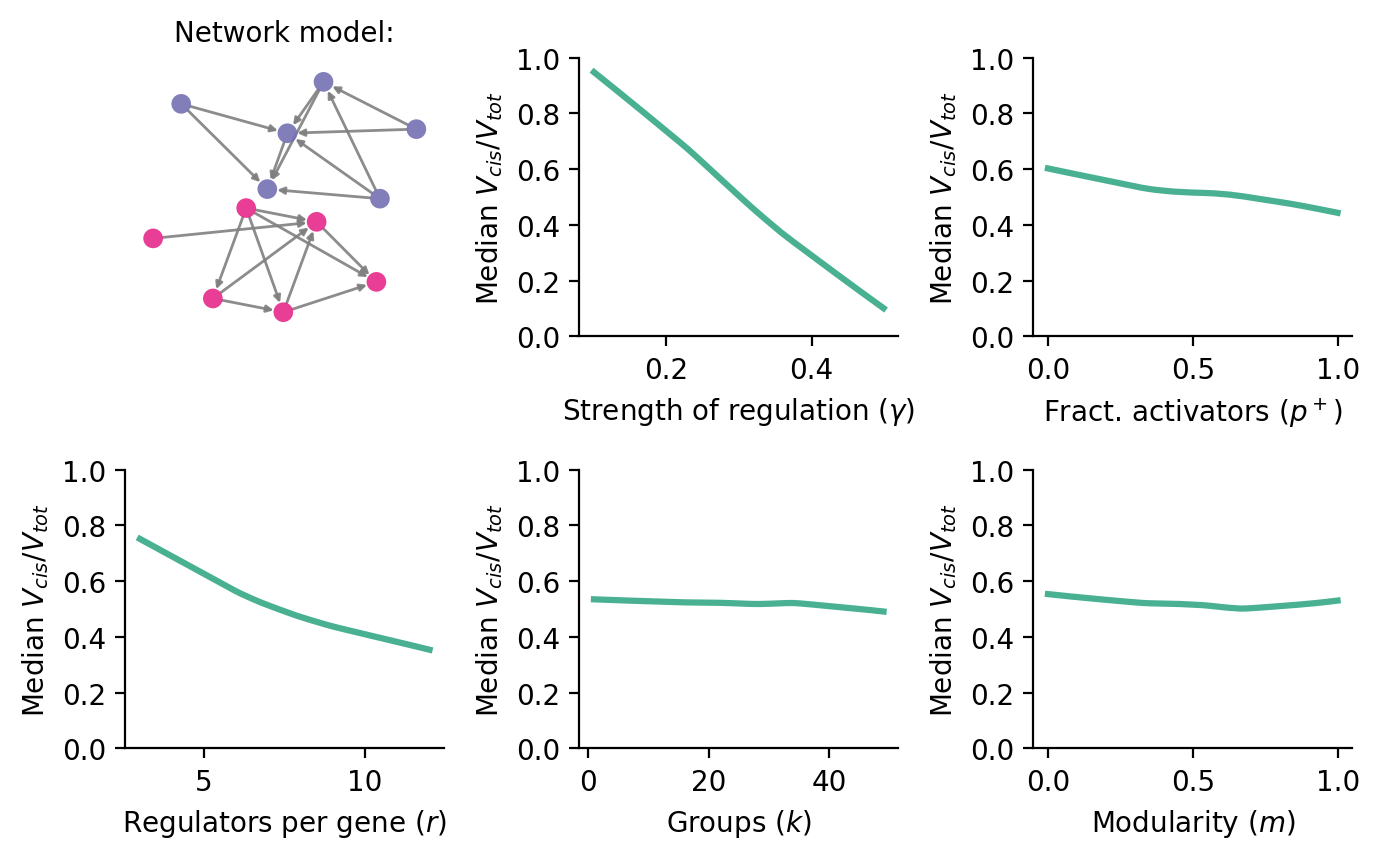

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['','gamma','p_up','r','k','m'],
                                ['',
                                 'Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 ]):
    ax = axs[ix, iy]
    if not par: 
        # make a graph
        M = grn().add_structure(method='ppm', n_genes=12, n_groups=2, m=0.95, r=2.5, hierarchy=True)#, seed=650)
        G = nx.DiGraph(M)
        E = [e for e in G.edges() if np.random.random() < 0.66]
        # draw it
        nx.draw_kamada_kawai(G, 
                     node_size=50,
                     node_color=[plt.get_cmap('Dark2')(i+2) for i in M.I],
                     linewidths=0,
                     width=1.0,
                     arrowsize=5,
                     alpha=0.9,
                     edge_color='gray',
                     edgelist=E,
                     ax=ax)
        
        ax.set_title('Network model:', fontsize='medium');
        continue  
    for i, b in enumerate([1]):
        sns.regplot(data = grns.loc[grns['hier']==b], 
                    x = par, 
                    y = 'Median '+r'$V_{cis}/V_{tot}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0.0, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    #if ix == 0 and iy == 0:
    #    ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

# Supplement

## Figure version with all the points

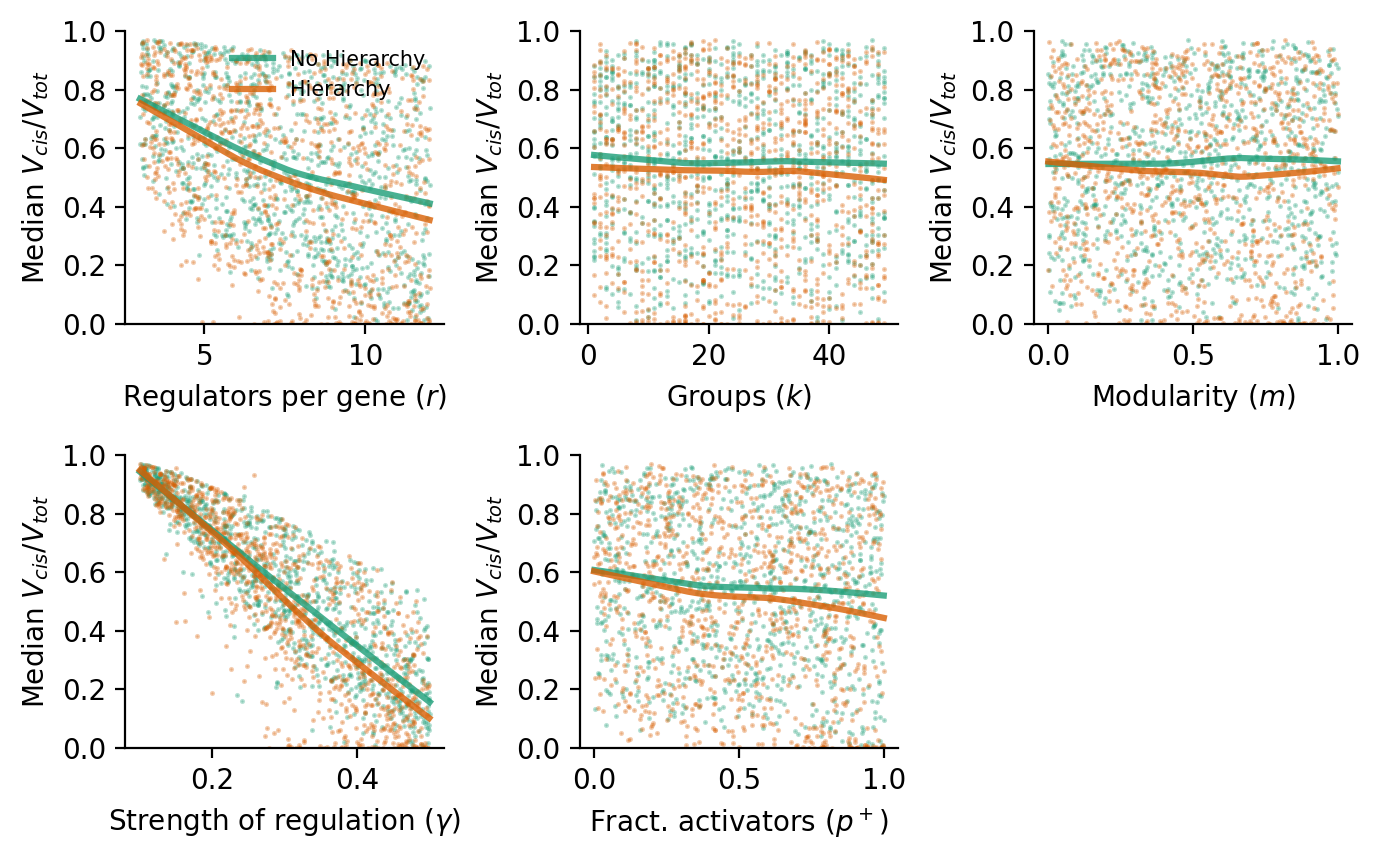

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['r','k','m','gamma','p_up',''],
                                ['Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 '']):
    ax = axs[ix, iy]
    if not par: 
        ax.axis('off');
        continue
    for i, b in enumerate([0,1]):
        sns.regplot(data = grns.loc[grns['hier']==b], 
                    x = par, 
                    y = 'Median '+r'$V_{cis}/V_{tot}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0.7, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    if ix == 0 and iy == 0:
        ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

## Parameter effects

Note $k$ has no effect and $m$ is only significant with hierarchy.

In [5]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{tot}$']

print(sm.ols('y ~ 1 + r + gamma + p_up + k + m + m:hier', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     3742.
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:39:44   Log-Likelihood:                 2278.7
No. Observations:                2000   AIC:                            -4543.
Df Residuals:                    1993   BIC:                            -4504.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.5411      0.009    174.

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [14]:
grns['Mean '+r'$V_{cis}/V_{tot}$'] = grns[r'$V_{cis}/V_{tot}$'].apply(lambda x: np.quantile(x, q=0.2))
grns['y2'] = grns['Mean '+r'$V_{cis}/V_{tot}$']

print(sm.ols('y2 ~ 1 + r + gamma + p_up + k + m + m:hier', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3412.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        15:37:11   Log-Likelihood:                 2114.9
No. Observations:                2000   AIC:                            -4216.
Df Residuals:                    1993   BIC:                            -4177.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4348      0.010    149.

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

## QTL effects

,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,y
249,1000,5.856581,48,0.398661,0.917712,True,0.522149,"[1.0, 1.0, 1.0, 0.6771436137442871, 1.0, 1.0, ...",0.131386,0.131386
1948,1000,5.337367,43,0.328736,0.970644,True,0.719753,"[1.0, 0.9024721886771785, 1.0, 1.0, 0.82227728...",0.276904,0.276904


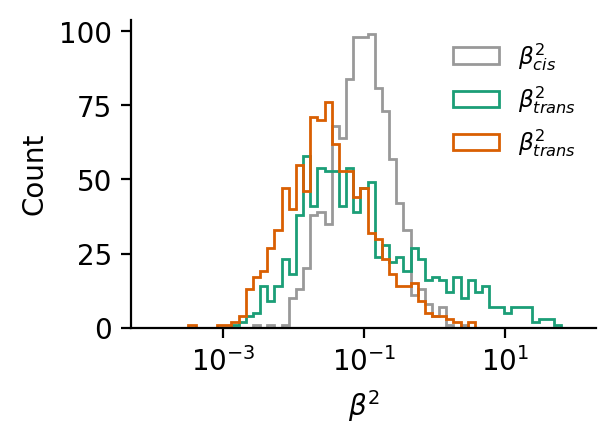

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=200)

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

x = grns.query('gamma < 0.4 & r < 6').sort_values('y').head(2)
display(x)

for ix in x.index:
    G = G_s[ix]
    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans}$'
            );
    
ax.legend(fontsize='small', frameon=False);
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');
sns.despine();

## Incoming and outgoing _trans_-effects

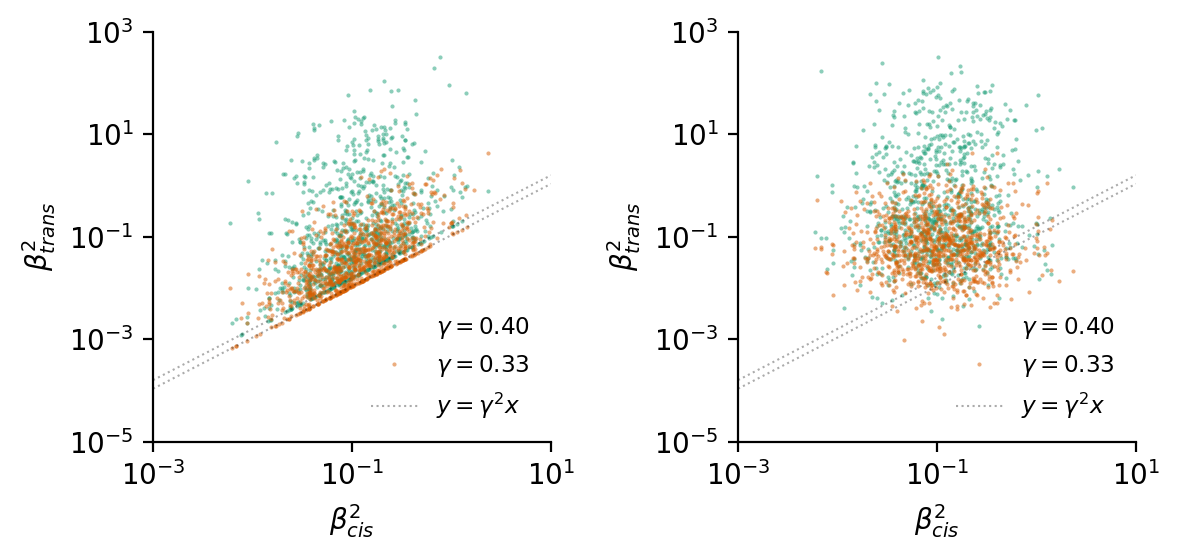

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.9), dpi=200);

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))

xl = np.array([1e-3,1e1])
yl = np.array([1e-5,1e3])

for i,(_,row) in enumerate(x.iterrows()):
    G = G_s[row.name]

    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    for j in range(2):
        axs[j].plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=j),
                 '.',
                 alpha=0.5,
                 ms=1,
                 label=r'$\gamma=$'+'{:.2f}'.format(row.gamma)
                );

        axs[j].plot(xl, row.gamma**2 * xl, 'k:', alpha=0.33, linewidth=0.75, label=r'$y = \gamma^2 x$' if i==1 else None);

for ax in axs:
    ax.legend(fontsize='small', frameon=False, loc='lower right');
    ax.set_xscale('log');
    ax.set_yscale('log');
    ax.set_xlabel(r'$\beta^2_{cis}$'); 
    ax.set_ylabel(r'$\beta^2_{trans}$'); 
    ax.set_xlim(xl);
    ax.set_ylim(yl);
    
sns.despine();
fig.tight_layout();

In [8]:
grns.query('0.1 < y & y < 0.4')

,n,r,k,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,y
3,1000,8.268387,2,0.471761,0.569281,True,0.306495,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.259139,0.259139
8,1000,6.781769,43,0.467752,0.287676,True,0.339073,"[1.0, 0.8204847921952217, 1.0, 1.0, 1.0, 0.820...",0.151421,0.151421
10,1000,8.688696,32,0.420330,0.833154,True,0.112450,"[1.0, 1.0, 0.8498508234471832, 0.8498508234471...",0.144329,0.144329
13,1000,6.717194,22,0.470200,0.082877,True,0.694281,"[1.0, 1.0, 1.0, 1.0, 0.8189415511350628, 1.0, ...",0.148537,0.148537
25,1000,8.789528,47,0.404544,0.871028,False,0.403168,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.204825,0.204825
...,...,...,...,...,...,...,...,...,...,...
1988,1000,6.342117,40,0.433203,0.346464,True,0.592709,"[1.0, 0.8419881261975402, 1.0, 0.8177394285818...",0.249955,0.249955
1990,1000,10.952913,21,0.456804,0.495172,True,0.012256,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.129336,0.129336
1994,1000,8.855537,47,0.470509,0.520143,True,0.971034,"[1.0, 0.8187469626509831, 0.7791533050152293, ...",0.290050,0.290050
1995,1000,8.439576,44,0.440258,0.113017,False,0.658641,"[1.0, 1.0, 1.0, 1.0, 0.837641932708862, 1.0, 1...",0.283118,0.283118


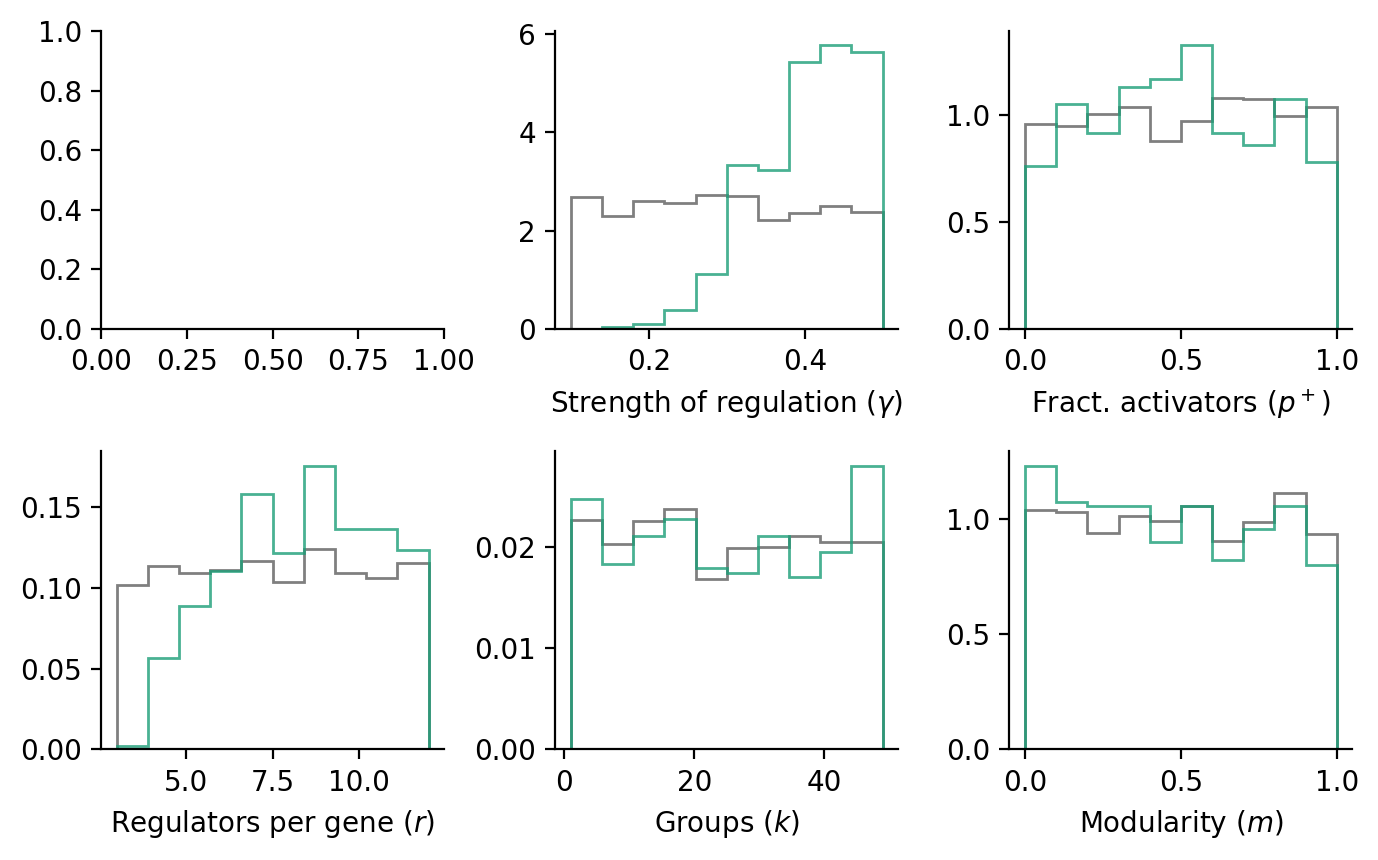

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['hier','gamma','p_up','r','k','m'],
                                ['Hierarchical organization (yes/no)',
                                 'Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 ]):
    if par == 'hier':
        continue
    else:
        _, bins, _ = axs[ix,iy].hist(grns[par], histtype='step', density=True, alpha=0.5, color='k');
        _ = axs[ix,iy].hist(grns.query('0.1 < y & y < 0.4')[par], bins=bins, histtype='step', density=True, alpha=0.8);
        
        axs[ix,iy].set_xlabel(label);
        
        
sns.despine();
plt.tight_layout();

In [108]:
import scipy

In [95]:
def count_triangles(G):
    return sum(G.subgraph(G.predecessors(n)).number_of_edges() for n in G.nodes())

def count_diamonds(G):
    return sum(len(set(G.predecessors(p1)) & set(G.predecessors(p2))) 
               for n in G.nodes() 
               for p1,p2 in itertools.combinations(G.predecessors(n), 2)
              )

grns['triangles'] = [count_triangles(G) for G in G_s]
grns['diamonds'] = [count_diamonds(G) for G in G_s]

  0%|                                                                                               | 0/2000 [30:32<?, ?it/s]


/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

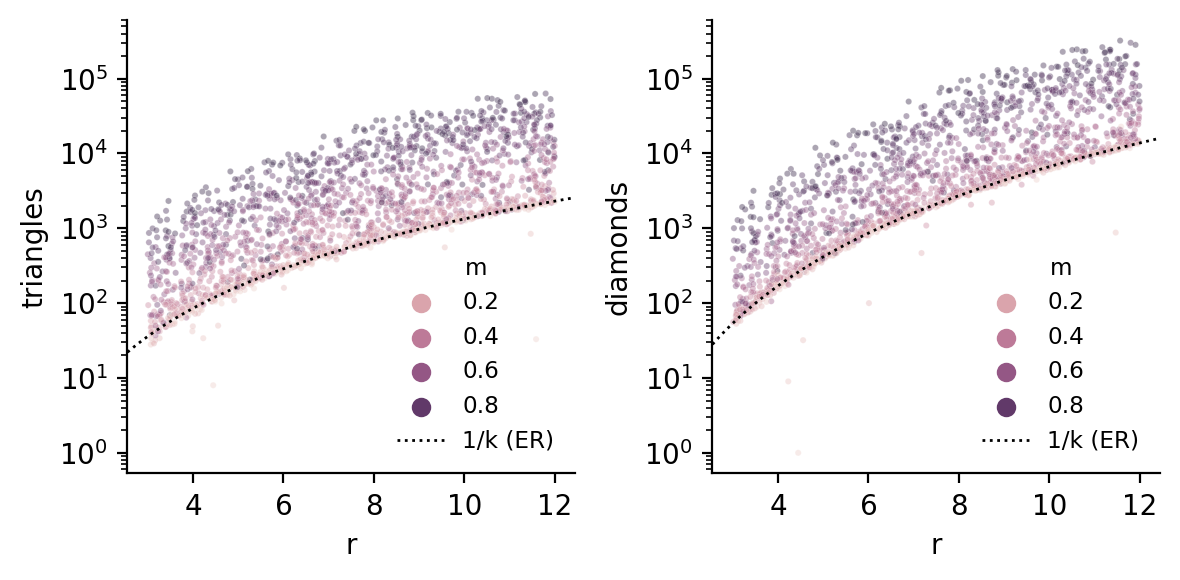

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=200)

sns.scatterplot(x = 'r', y = 'triangles', hue = 'm', alpha = 0.4, s = 5, data = grns, ax = ax[0]);
ax[0].set_yscale('log');
xl = ax[0].get_xlim()
xx = np.linspace(*xl, grns.shape[0]);
ax[0].plot(xx, scipy.special.comb(grns.n, 3) * (2 * xx / (grns.n - 1)) ** 3, 'k:', linewidth=1, label='1/k (ER)');
ax[0].set_xlim(xl);
ax[0].legend(frameon=False, title='m', fontsize='small', title_fontsize='small');

sns.scatterplot(x = 'r', y = 'diamonds', hue = 'm', alpha = 0.4, s = 5, data = grns, ax = ax[1]);
ax[1].set_yscale('log');
ax[0].set_ylim(ax[1].get_ylim());
xl = ax[1].get_xlim()
xx = np.linspace(*xl, grns.shape[0]);
ax[1].plot(xx, scipy.special.comb(grns.n, 4) * (2 * xx / (grns.n - 1)) ** 4, 'k:', linewidth=1, label='1/k (ER)');
ax[1].set_xlim(xl);
ax[1].legend(frameon=False, title='m', fontsize='small', title_fontsize='small');

fig.tight_layout();
sns.despine();

In [123]:
n = 1352
k = 13

k * scipy.special.comb(n/k, 3) + \
k * scipy.special.comb(n/k, 2) * (n - n/k) + \
scipy.special.comb(k, 3) * (n/k)**3 == scipy.special.comb(n, 3)

2 * k * r * ( (1-m) * np.ones((k,k)) + (m*k - 1)*np.eye(k) ) / ((k-1) * (n_genes-1))

True

### Theoretical result

For the Erdos-Renyi graph, $\mathbb{E}[\text{# of triangles}] = {n \choose 3} p^3 = \frac{4 n(n-2) r^3}{3 (n-1)^2} \approx \frac{4}{3} r^3$, since here $p = 2r / (n-1)$. 

For the planted partition model, we can extend this to 

$ \mathbb{E}[\text{# of triangles}] = k {n/k \choose 3} p^3 + k (k - 1) {n/k \choose 2} (n/k) p q^2 + {k \choose 3} (n/k)^3 q^3$

where $p = \frac{2 k r m}{n-1}$ and $q = \frac{2 k r (1-m)}{(k-1)(n-1)}$. Plugging in, 

$ \mathbb{E}[\text{# of triangles}] = \frac{k}{6} \frac{n}{k} \frac{n-k}{k} \frac{n-2k}{k} \left(\frac{2krm}{n-1}\right)^3 + \frac{k (k - 1)}{2} \frac{n}{k} \frac{n-k}{k} \frac{n}{k} \frac{2krm}{n-1} \left( \frac{2 k r (1-m)}{(k-1)(n-1)} \right)^2 + \frac{k}{6} (k-1)(k-2) (n/k)^3 \left( \frac{2 k r (1-m)}{(k-1)(n-1)} \right)^3 $

and simplifying each term,

$ \mathbb{E}[\text{# of triangles}] = \frac{4 k (r m)^3}{3} \frac{n(n-k)(n-2k)}{(n-1)^3} + \frac{4 k r^3 m (1-m)^2 n^2 (n-k)}{(n-1)^3 (k-1)} + \frac{4 n^3 k (k-2) r^3 (1-m)^3}{3 (n-1)^3 (k-1)^2} $

then collecting,

$ \mathbb{E}[\text{# of triangles}] = \frac{4}{3} k n \left( \frac{r}{(n-1)} \right)^3 \left( m^3 (n-k)(n-2k) + 3 m (1-m)^2 n (n-k)\frac{1}{k-1} + (1-m)^3 n^2 \frac{k(k-2)}{(k-1)^2} \right)$

and pushing stuff back,

$ \mathbb{E}[\text{# of triangles}] = \frac{4}{3} r^3 \left(k m^3 \frac{n(n-k)(n-2k)}{(n-1)^3} + 3 m (1-m)^2 \frac{k}{k-1} \frac{n^2 (n-k)}{(n-1)^3} + (1-m)^3 \frac{k(k-2)}{(k-1)^2} \frac{n^3}{(n-1)^3} \right)$

In [97]:
print(sm.ols('triangles ~ 1 + r + k + m', data = grns.query('hier')).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              triangles   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     412.8
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          3.53e-175
Time:                        16:38:56   Log-Likelihood:                -10171.
No. Observations:                1018   AIC:                         2.035e+04
Df Residuals:                    1014   BIC:                         2.037e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.688e+04    656.509    -25.713      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [107]:
print(sm.ols('diamonds ~ 1 + r + k + m', data = grns.query('hier')).fit().summary());

                            OLS Regression Results                            
Dep. Variable:               diamonds   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     304.9
Date:                Fri, 01 Nov 2024   Prob (F-statistic):          4.86e-141
Time:                        16:49:55   Log-Likelihood:                -11708.
No. Observations:                1018   AIC:                         2.342e+04
Df Residuals:                    1014   BIC:                         2.344e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.667e+04   2971.935    -22.432      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [99]:
print(sm.ols('y ~ 1 + r + gamma + p_up + m + hier + diamonds', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     3813.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:38:56   Log-Likelihood:                 2295.9
No. Observations:                2000   AIC:                            -4578.
Df Residuals:                    1993   BIC:                            -4539.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5860      0.009    172.225   

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego